In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model


def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array


def noise(array, noise_factor=1, mean=0, std=1):
    """
    Adds random noise to each image in the supplied array.
    """
    noisy_array = array + noise_factor * np.random.normal(
        mean, std, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

def display_test(array1, array2, array3):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]
    images3 = array3[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2, image3) in enumerate(zip(images1, images2, images3)):
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(image1)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(image2)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n + n)
        plt.imshow(image3)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


    plt.show()


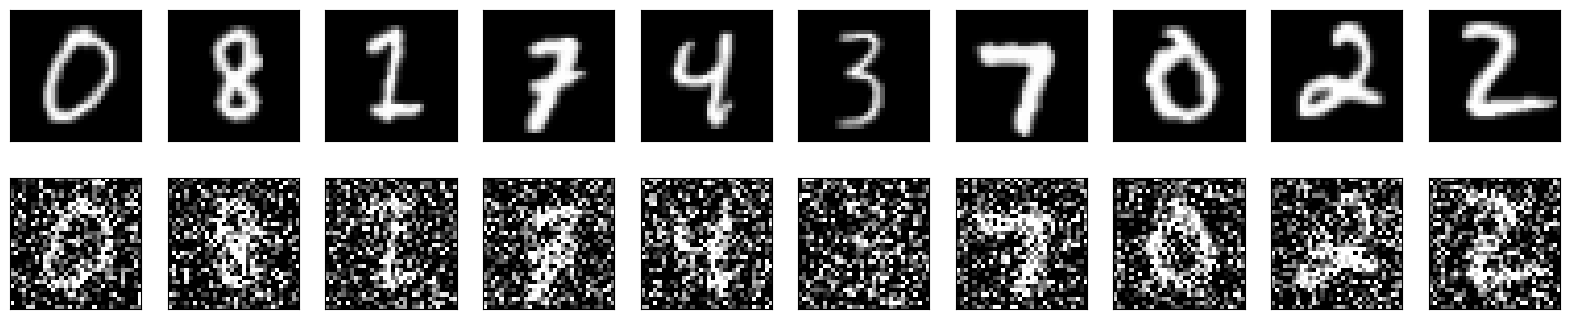

In [2]:
# Since we only need images from the dataset to encode and decode, we
# won't use the labels.
(train_data, _), (test_data, _) = mnist.load_data()

# Normalize and reshape the data
train_data = preprocess(train_data)
test_data = preprocess(test_data)

#train_data = train_data[..., tf.newaxis]
#test_data = test_data[..., tf.newaxis]

# Resize the data to 32x32
train_data = tf.image.resize(train_data, [32, 32]).numpy()
test_data = tf.image.resize(test_data, [32, 32]).numpy()

# Create a copy of the data with added noise
noisy_train_data = noise(train_data, noise_factor=1, mean=0, std=0.6)
noisy_test_data = noise(test_data, noise_factor=1, mean=0, std=0.6)

# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)

In [3]:
train_data.shape, test_data.shape

((60000, 32, 32, 1), (10000, 32, 32, 1))

# Model Training

In [4]:
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Conv2DTranspose, UpSampling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from keras.optimizers import Adam
from AE_RESNET.resnetAE import ResNetAE
from keras.callbacks import EarlyStopping
import tensorflow as tf

In [5]:
resnet34AE = ResNetAE(input_shape = (32, 32, 1), output_channels=1,
                      bottleneck_layers=[3,4,6,3],bottleneck_strides=[1,2,2,2], 
                      bottleneck_num_layer=2)
resnet34AE.summary()

Model: "ResNetAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 ResNet_encoder (Functional)  (None, 1, 1, 512)        22717376  
                                                                 
 ResNet_decoder (Functional)  (None, 32, 32, 1)        27361925  
                                                                 
Total params: 50,079,301
Trainable params: 50,045,123
Non-trainable params: 34,178
_________________________________________________________________


In [6]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
resnet34AE.compile(optimizer=optimizer, loss='binary_crossentropy')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = resnet34AE.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=40,
    batch_size=64,
    shuffle=True,
    validation_data=None,
    validation_split=0.1,
    callbacks=[early_stopping],
)

Epoch 1/40
844/844 [==============================] - 54s 55ms/step - loss: 0.4838 - val_loss: 0.5621
Epoch 2/40
844/844 [==============================] - 45s 54ms/step - loss: 0.2870 - val_loss: 0.3477
Epoch 3/40
844/844 [==============================] - 45s 54ms/step - loss: 0.2083 - val_loss: 0.2079
Epoch 4/40
844/844 [==============================] - 45s 54ms/step - loss: 0.1740 - val_loss: 0.1643
Epoch 5/40
844/844 [==============================] - 45s 54ms/step - loss: 0.1556 - val_loss: 0.1677
Epoch 6/40
844/844 [==============================] - 45s 54ms/step - loss: 0.1443 - val_loss: 0.1470
Epoch 7/40
844/844 [==============================] - 45s 54ms/step - loss: 0.1370 - val_loss: 0.1400
Epoch 8/40
844/844 [==============================] - 45s 53ms/step - loss: 0.1321 - val_loss: 0.1430
Epoch 9/40
844/844 [==============================] - 46s 54ms/step - loss: 0.1285 - val_loss: 0.1355
Epoch 10/40
844/844 [==============================] - 46s 55ms/step - loss: 0.125

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_lr(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

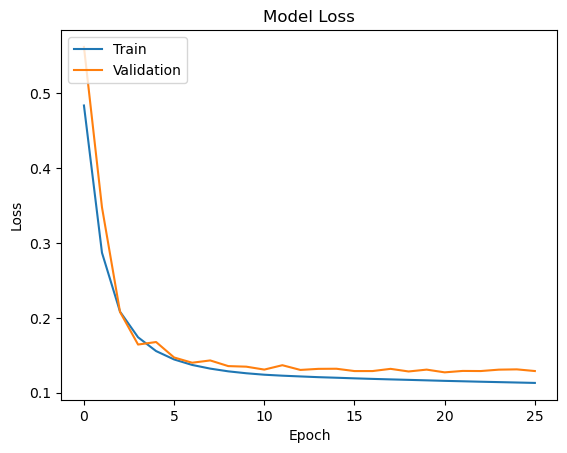

In [8]:
plot_lr(history)

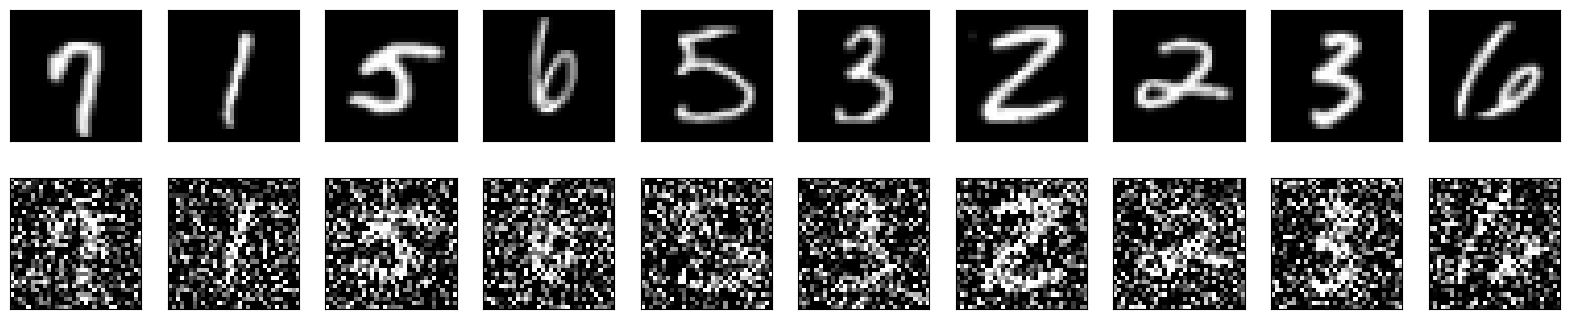

In [9]:
display(test_data, noisy_test_data)

313/313 [==============================] - 5s 15ms/step


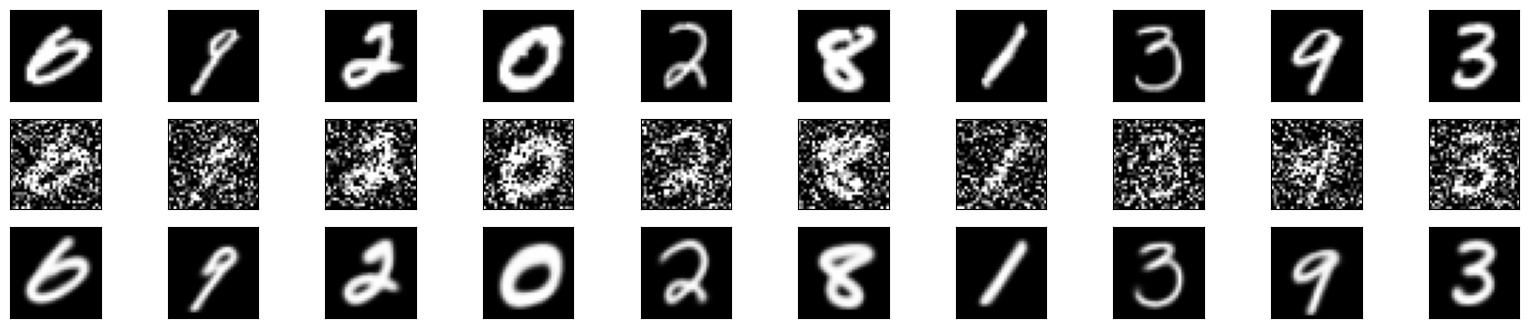

In [10]:
predicted_test_data = resnet34AE.predict(noisy_test_data)

display_test(test_data, noisy_test_data, predicted_test_data)

In [11]:
# ssim score
test_data = tf.cast(test_data, tf.float32)
predicted_test_data = tf.cast(predicted_test_data, tf.float32)
noisy_test_data = tf.cast(noisy_test_data, tf.float32)

ssim = tf.image.ssim(test_data, predicted_test_data, max_val=1.0)
ssim = tf.reduce_mean(ssim)
print('SSIM Score:',ssim)

ssim2 = tf.image.ssim(test_data, noisy_test_data, max_val=1.0)
ssim2 = tf.reduce_mean(ssim2)
print('SSIM Score:',ssim2)

# psnr score
psnr = tf.image.psnr(test_data, predicted_test_data, max_val=1.0)
psnr = tf.reduce_mean(psnr)
print('PSNR Score:',psnr)

psnr2 = tf.image.psnr(test_data, noisy_test_data, max_val=1.0)
psnr2 = tf.reduce_mean(psnr2)
print('PSNR Score:',psnr2)

SSIM Score: tf.Tensor(0.84151465, shape=(), dtype=float32)
SSIM Score: tf.Tensor(0.27616242, shape=(), dtype=float32)
PSNR Score: tf.Tensor(20.66716, shape=(), dtype=float32)
PSNR Score: tf.Tensor(8.253913, shape=(), dtype=float32)


In [13]:
resnet34AE.save('final_models/resnet34AE_mnist_lr0001.h5')